In [10]:
import numpy as np
import control as ct
import matplotlib.pyplot as plt
import pickle 

from parameters import dict_with_params

folder_name = "pkl_objects"
file_name = "function_dxdt.pkl"
file = open(folder_name + "/" + file_name, "rb")
f_model_sym = pickle.load(file)
file.close()    


In [12]:
# decode symbolic nonlinear object
import sympy as sp

# define parameters
g, L, D, r, J_v_x, J_v_y, J_v_z, m_v, J_w_xz, J_w_y, m_w = sp.symbols(
    "g, L, D, r, J_v_x, J_v_y, J_v_z, m_v, J_w_xz, J_w_y, m_w", positive=True
)
# define state
D_psi_v_z_t, psi_v_z_t = sp.symbols("D_psi_v_z_t psi_v_z_t", real=True)
D_theta_v_y_t, theta_v_y_t = sp.symbols("D_theta_v_y_t theta_v_y_t", real=True)
v_v_x_t, x_v_t = sp.symbols("v_v_x_t x_v_t", real=True)
# define control
T_theta_t, T_psi_t = sp.symbols("T_theta_t T_psi_t", real=True)

param_subs = {
    g: dict_with_params["g"],
    L: dict_with_params["L"],
    D: dict_with_params["D"],
    r: dict_with_params["r"],
    J_v_x: dict_with_params["J_v_x"],
    J_v_y: dict_with_params["J_v_y"],
    J_v_z: dict_with_params["J_v_z"],
    m_v: dict_with_params["m_v"],
    J_w_xz: dict_with_params["J_w_xz"],
    J_w_y: dict_with_params["J_w_y"],
    m_w: dict_with_params["m_w"],
}

f_unparam_sym = f_model_sym.subs(param_subs)

f_model_lambda = sp.lambdify(
    (
        x_v_t,
        v_v_x_t,
        theta_v_y_t,
        D_theta_v_y_t,
        psi_v_z_t,
        D_psi_v_z_t,
        T_theta_t,
        T_psi_t,
    ),
    f_unparam_sym,
)


def f_model(states, controls) -> np.ndarray:
    x_v_t, v_v_x_t, theta_v_y_t, D_theta_v_y_t, psi_v_z_t, D_psi_v_z_t = states
    T_theta_t, T_psi_t = controls
    return f_model_lambda(
        x_v_t,
        v_v_x_t,
        theta_v_y_t,
        D_theta_v_y_t,
        psi_v_z_t,
        D_psi_v_z_t,
        T_theta_t,
        T_psi_t,
    )

In [17]:
def self_balancing_robot_ode(t, x, u, params):
    dx_dt= f_model(x,u)
    return dx_dt

def self_balance_robot_output(t, x, u, params) -> np.array:
    return x

# define nonlinear system
self_balancing_robot_system = ct.NonlinearIOSystem(
    updfcn=self_balancing_robot_ode,
    outfcn=self_balance_robot_output,
    states=6,
    name="self_balancing_robot",
    inputs=["T1", "T2"],  # 2 inputs
    outputs=[
        "x_act[0]",
        "x_act[1]",
        "x_act[2]",
        "x_act[3]",
        "x_act[4]",
        "x_act[5]",
    ],  # 6 outputs
    params=dict_with_params,
)

linearize_state = np.zeros(6)
linearize_control = np.zeros(2)

linearized_system = self_balancing_robot_system.linearize(linearize_state, linearize_control)
# linearized_system = ct.rss(6, 6, 2)
A, B, C, D = ct.ssdata(linearized_system)
Q = np.diag([1, 1, 1, 1, 1, 1])
R = np.diag([1, 1])
K_lqr, a, b = ct.lqr(A, B, Q, R)

# controller output function
def control_output(t, x, u, params):
    K = params.get("K", np.zeros((2, 6)))  
    x_error = u  
    u_feed_forward_equilibrium_point = np.zeros(2)  # when equilibrium point is with not zero control
    return u_feed_forward_equilibrium_point + K @ x_error

# define controller 
controller = ct.NonlinearIOSystem(
    None,  # there is no state in this function
    control_output,
    name="controller",
    inputs=[
        "x_err[0]",
        "x_err[1]",
        "x_err[2]",
        "x_err[3]",
        "x_err[4]",
        "x_err[5]",
    ],  # 6 inputs 
    outputs=["T1", "T2"],  # 2 output from regulator
    params={"K": K_lqr},
)

# define sum block
summer_block = ct.summing_junction(
    inputs=["x_ref", "-x_act"],
    output="x_err",
    dimension=6,  # need to operate with vectors
)

# creating closed-loop system
closed_loop_system = ct.interconnect(
    (self_balancing_robot_system, controller, summer_block),
    inputs=[
        "x_ref[0]",
        "x_ref[1]",
        "x_ref[2]",
        "x_ref[3]",
        "x_ref[4]",
        "x_ref[5]",
    ],  # system input (reference)
    outputs=[
        "x_act[0]",
        "x_act[1]",
        "x_act[2]",
        "x_act[3]",
        "x_act[4]",
        "x_act[5]",
    ],  # system output (actual state)
)

# checking number of inputs and outputs of individual system components
print(
    f"closed_loop_system: ninputs={closed_loop_system.ninputs}, noutputs={closed_loop_system.noutputs}, nstates={closed_loop_system.nstates}"
)
print(
    f"self_balancing_robot_system: ninputs={self_balancing_robot_system.ninputs}, noutputs={self_balancing_robot_system.noutputs}, nstates={self_balancing_robot_system.nstates}"
)
print(
    f"controller: ninputs={controller.ninputs}, noutputs={controller.noutputs}, nstates={controller.nstates}"
)
print(
    f"summer_block: ninputs={summer_block.ninputs}, noutputs={summer_block.noutputs}, nstates={summer_block.nstates}"
)

display(closed_loop_system)

closed_loop_system: ninputs=6, noutputs=6, nstates=6
self_balancing_robot_system: ninputs=2, noutputs=6, nstates=6
controller: ninputs=6, noutputs=2, nstates=0
summer_block: ninputs=12, noutputs=6, nstates=0


<InterconnectedSystem:sys[8]:['x_ref[0]', 'x_ref[1]', 'x_ref[2]', 'x_ref[3]', 'x_ref[4]', 'x_ref[5]']->['x_act[0]', 'x_act[1]', 'x_act[2]', 'x_act[3]', 'x_act[4]', 'x_act[5]']>

<class 'control.timeresp.TimeResponseData'>


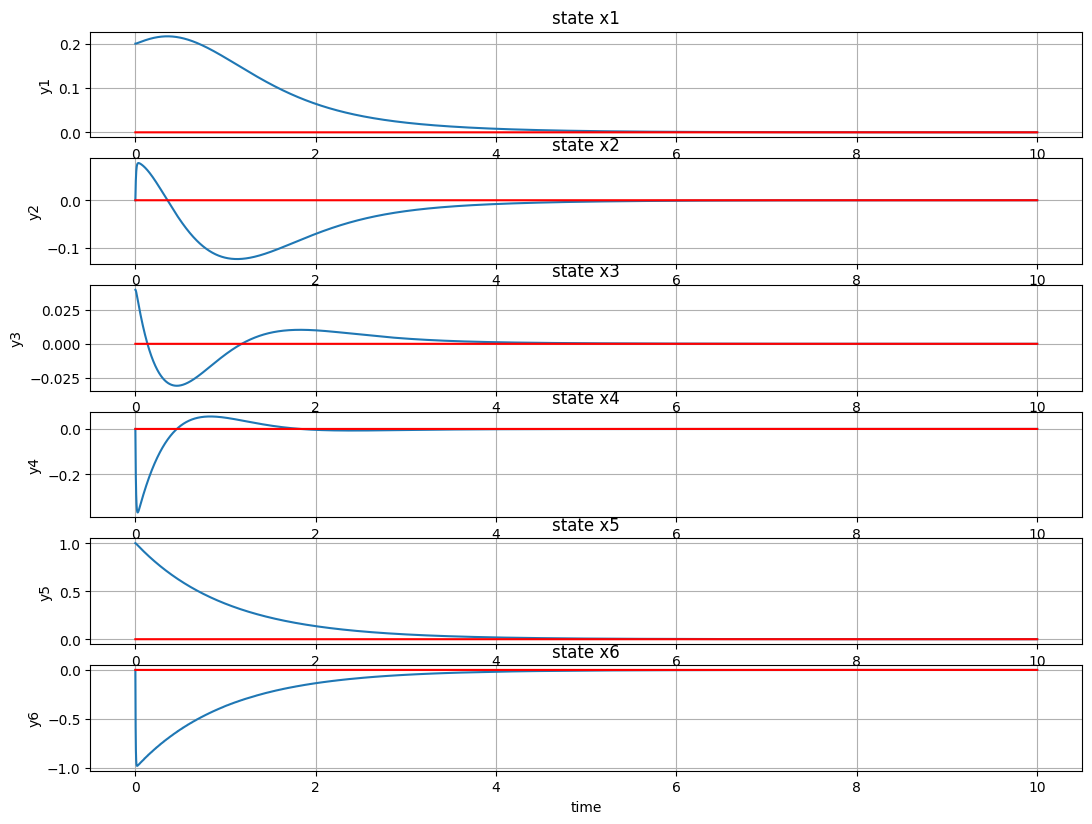

In [18]:
initial_state = np.array([0.2, 0.0, 0.04, 0.0, 1, 0.0])
desired_state = np.array([0.0, 0.0, 0.0, 0.0, 0.0, 0.0])
time = np.linspace(0, 10, 10001)
desired_state_in_time = np.tile(desired_state.reshape(6, 1), time.size)
resp = ct.input_output_response(
    closed_loop_system, time, desired_state_in_time, initial_state
)

out_t = resp.time
out_y = resp.outputs
out_x = resp.states
out_u = resp.inputs

print(type(resp))
fig = plt.figure()
for i in range(1, 7):
    subplot = plt.subplot(6, 1, i)
    plt.plot(out_t, out_x[i - 1, :])
    plt.plot(out_t, desired_state_in_time[i-1,:],'-r')
    plt.title(f"state x{i}")
    plt.grid()
    plt.xlabel("time")
    plt.ylabel(f"y{i}")

width, height = fig.get_size_inches()
fig.set_size_inches(width * 2, height * 2)